# Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары для покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

### Метрики
*MAE* < 8.0

# 1. Исследовательский анализ данных

Поскольку данные нуждаются лишь в минимальной предобработке, а объём исследовательского анализа - небольшой, объединим эти два раздела в один единый.

##  Настройка среды и загрузка данных

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import display as d
import warnings

Настроим среду.

In [2]:
sns.set()
warnings.filterwarnings('ignore')

seed_0 = 123

## Функции

In [3]:
# The function displays the general information about the dataset

def info_general(df):
    d(df.head())
    d(df.info())
    d(df.describe())

In [4]:
# The function plots the frequency distribution plot and the boxenplot

def dist_boxen_plot(series):
    plt.figure(figsize=(16, 12))

    plt.subplot(211)
    plt.title('Frequency distribution plot for the age')
    sns.distplot(series, bins=int(round(series.max() - series.min(), 0)), kde=False)
    plt.xticks(np.arange(0, int(series.max()), 5))

    plt.subplot(212)
    plt.title('Boxplot diagram plot for the age')
    sns.boxenplot(series)
    plt.xticks(np.arange(0, int(series.max()), 5))

    plt.show()

##  Ознакомление с данными

Загрузим данные из файла.

In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Ознакомимся с информацией о датасете.

In [6]:
info_general(labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Пропуски, выбросы, аномалии - отсутствуют. 

Выполним проверку на наличие дубликатов.

In [7]:
labels.duplicated().sum()

0

Дубликатов нет.

Сохраним информацию об исходной длине датасета.

In [8]:
labels_count_original = labels.count().max()
labels_count_original

7591

## Графический анализ

Построим распределение значений столбца *real_age*, а также диаграмму boxplot.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


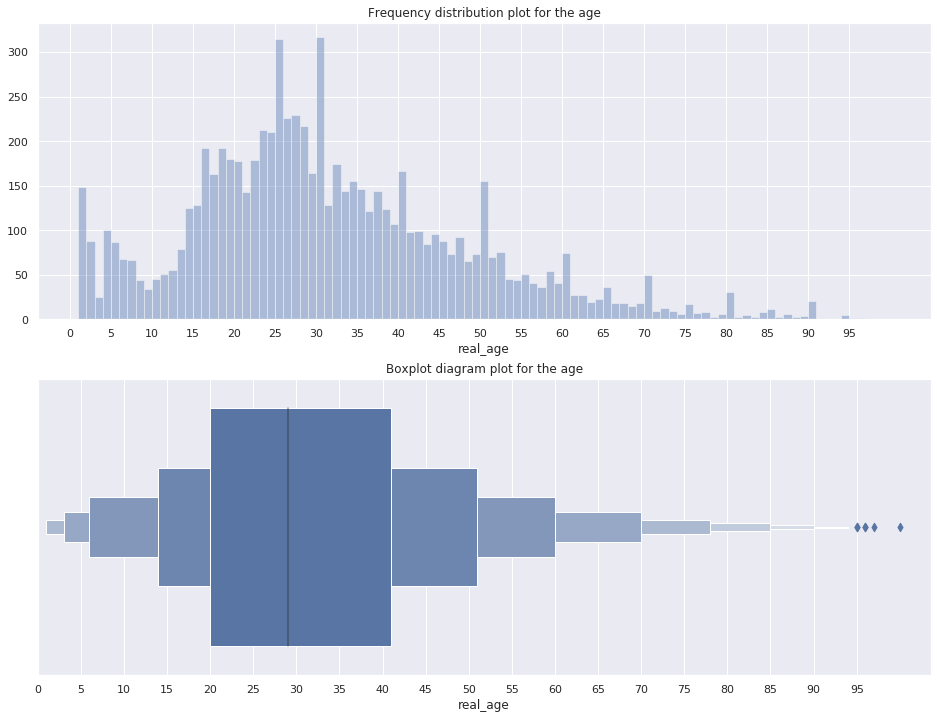

In [9]:
dist_boxen_plot(labels.real_age)

На гистограмме прослеживаются **аномалии**: некоторые значения, **кратные** 10 и 5, встречаются **чаще** остальных. Это может **повлиять** на обучение: что модель чаще будет видеть на обучении, то впоследствии и будет чаще возвращать в качестве ответа: человек в возрасте 78 лет, вероятно, будет определён как 75- или 80-летний.

Распределение **возраста** людей в некоторой выборке есть **распределение Пуассона**: нижняя (левая) граница - определена (конечна), и по мере приближения к ней частота не обязательно будет стремиться к нулю. Верхняя (правая) граница - открыта, и частота по мере увеличения значения (в нашем случае - возраста) ассимптотически приближается к нулю.

В целях экономии машинного времени, необходимого для обучения модели, попробуем разумно уменьшить размер выборки.

Рассматривая данные в **контексте** задачи (определение возраста покупателей магазина), мы можем **отбросить** людей со **слишком малым** возрастом: малолетние дети, как правило, не ходят по магазинам самостоятельно и, к тому же, располагают лишь незначительной суммой денег.

На гистограмме имеется **локальный минимум** в точке *real_age*=9. Можно принять это значение в качестве **границы**, ниже которой мы отбросим все объекты. Но что касается контроля добросовестности кассиров, то лучше эту границу снизить **ещё** ниже - до **5** лет: если в 7-8 лет ребёнок в отдельных случаях ещё может попытаться купить алкоголь, то попытка купить алкоголь ребёнком в возрасте до 5 лет практически исключена.

Примем **нижнюю** границу возраста равной ***real_age*=5**.

В качестве верхней границы возраста можно принять значение *real_age*=80. Покупателей **старше 80 лет** - очень **мало**, и покупают они, как правило, только самое необходимое и недорогое: их вклад в выручку магазина **невелик**.

Примем **верхнюю** границу возраста равной ***real_age*=80** и удалим объекты, выходящие за границы.

In [10]:
real_age_bounds = (5, 80)

labels.drop(index=labels[(labels.real_age < real_age_bounds[0]) | (labels.real_age > real_age_bounds[1])].index, inplace=True)
labels.reset_index(drop=True, inplace=True)

In [11]:
info_general(labels)

,file_name,real_age
0,000001.jpg,18
1,000002.jpg,80
2,000003.jpg,50
3,000004.jpg,17
4,000005.jpg,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7147 entries, 0 to 7146
Data columns (total 2 columns):
file_name    7147 non-null object
real_age     7147 non-null int64
dtypes: int64(1), object(1)
memory usage: 111.8+ KB


None

,real_age
count,7147.000000
mean,32.031202
std,15.237416
min,5.000000
25%,21.000000
50%,29.000000
75%,41.000000
max,80.000000


In [12]:
labels.count().max() / labels_count_original

0.9415096825187722

Удалено менее 6% датасета, что вполне приемлемо.

## Просмотр фотографий

Загрузим фотографии с помощью загрузчика данных.

In [13]:
%%time

train_datagen = ImageDataGenerator(rescale=1./255.)
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(244, 244),
    batch_size=32,
    class_mode='raw',
    seed=seed_0
)

Found 7147 validated image filenames.
CPU times: user 306 ms, sys: 358 ms, total: 664 ms
Wall time: 1min 20s


Выведем на экран 12 фотографий.

In [14]:
features, target = next(train_datagen_flow)

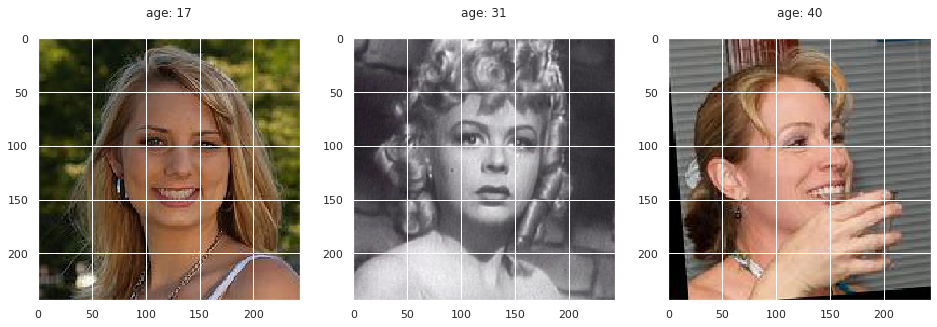

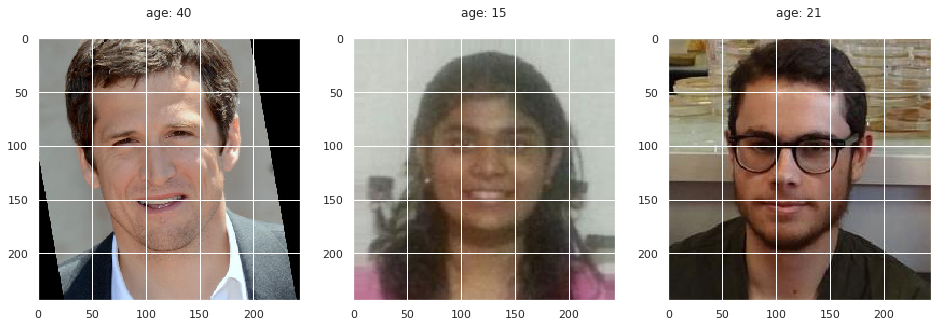

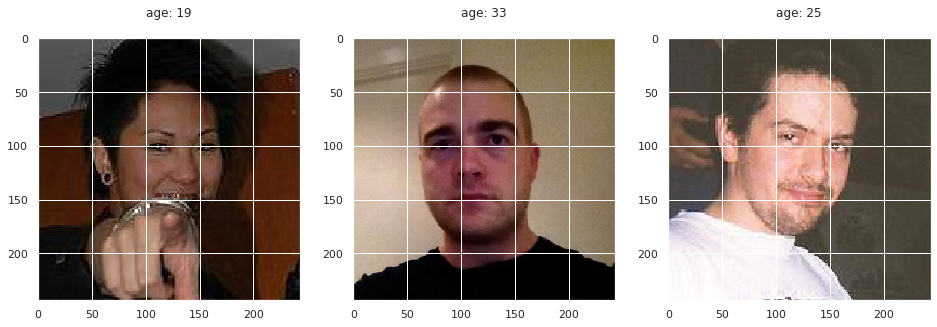

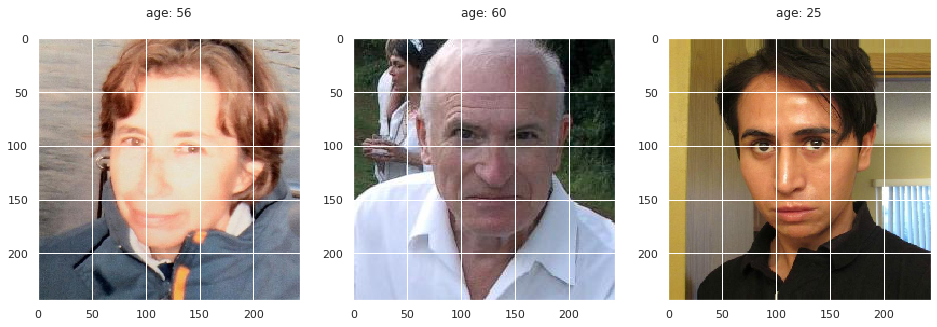

In [15]:
for i in range(0, 12, 3):
    plt.figure(figsize=(16, 6))
    
    for j in range(3):
        plt.subplot(131+j)
        plt.title(f'age: {target[i+j]}\n')
        plt.imshow(features[i+j])
    
    plt.show()

Посмотрим, какое количество различных возрастов представлено тем или иным количеством фотографий.

In [16]:
labels.pivot_table(index='real_age', values='file_name', aggfunc='count').describe()

,file_name
count,76.000000
mean,94.039474
std,74.302165
min,3.000000
25%,35.500000
50%,74.500000
75%,144.750000
max,317.000000


**Некоторые** возрасты представлены всего лишь **несколькими** фотографиями (минимальное число - 3). **Половина** возрастов представлена количеством фотографий, **не превышающим 75**. Максимум - 317, но мы знаем (из гистограммы), что подобных категорий - всего две, а самые **многочисленные группы** (20-40 лет) представлены, как правило, **примерно 200** фотографиями каждая (по годам). **В среднем** каждый возраст представлен **94** фотографиями.

Такого количества данных, возможно, будет **недостаточно** для обучения модели. Если результаты обучения получатся неудовлетворительными, можно будет попробовать применить следующие методы.
* **Аугментация**. Здесь мы практически ничем не ограничены: можно поворачивать, отражать, смещать - делать что угодно. Возраст человека на фотографии от таких манипуляций визуально не изменится. Но, конечно же, без фанатизма. Не получится только растягивать-сжимать.
* **Объединение возрастов в группы**. Например, от 3 до 10 возрастов на группу в зависимости от многочисленности. Чем старше возраст, тем шире можно объединять. На критичные значения (например, 18 лет) обратить особое внимание (постараться добиться максимально точной работы модели вокруг таких значений).

Второй метод - на **крайний** случай, когда уже исчерпаны все остальные возможности: его применение может трактоваться как **отступление** от ТЗ. Такие моменты необходимо **согласовывать** с заказчиком.

##  Вывод по предобработке и исследовательскому анализу

Из датасета удалены нерелевантные объекты - люди в возрасте младше 5 и старше 80 лет. Удалено 6% данных.

Количество объектов в наборе данных составляет всего лишь около 7000 фотографий, а в среднем на каждый возраст - менее ста. Этого может оказаться недостаточно для обучения. Тогда понадобится аугментация (характер изображений позволяет применять её почти без ограничений). Если не поможет и аугментация, придётся выполнять группировку по возрастам. Группировка - крайняя мера, требующая согласования с заказчиком, так как в этом случае затрагивается ТЗ (по ТЗ требуется определить конкретный возраст, а не группу).

# 2. Обучение модели

##  Код для обучения модели

Код в этом разделе запускался отдельно на машине с GPU, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(244, 244),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(244, 244),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

##  Лог процесса обучения и результаты

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2020-10-09 21:44:18.683202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-10-09 21:44:18.973939: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 48s - loss: 182.2178 - mae: 9.9516 - val_loss: 399.2750 - val_mae: 14.9900
Epoch 2/10
178/178 - 38s - loss: 78.5549 - mae: 6.7094 - val_loss: 371.9521 - val_mae: 14.3799
Epoch 3/10
178/178 - 38s - loss: 43.5166 - mae: 5.0912 - val_loss: 468.2337 - val_mae: 16.6664
Epoch 4/10
178/178 - 38s - loss: 30.9003 - mae: 4.3259 - val_loss: 139.4399 - val_mae: 9.0835
Epoch 5/10
178/178 - 38s - loss: 22.6004 - mae: 3.6707 - val_loss: 95.6187 - val_mae: 7.4652
Epoch 6/10
178/178 - 39s - loss: 16.3460 - mae: 3.1081 - val_loss: 70.8022 - val_mae: 6.3392
Epoch 7/10
178/178 - 38s - loss: 13.3827 - mae: 2.8034 - val_loss: 64.6014 - val_mae: 6.0395
Epoch 8/10
178/178 - 38s - loss: 11.3625 - mae: 2.5717 - val_loss: 70.4336 - val_mae: 6.4292
Epoch 9/10
178/178 - 38s - loss: 10.1101 - mae: 2.4258 - val_loss: 64.9453 - val_mae: 5.9203
Epoch 10/10
178/178 - 38s - loss: 9.0427 - mae: 2.2727 - val_loss: 65.6994 - val_mae: 5.9456
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.6994 - mae: 5.9456
Test MAE: 5.9456

```

# 3. Анализ обученной модели

Модель построена на основе **предварительно обученной** модели. Предварительно обученная модель - модель, обученная нейронной сетью ***ResNet50*** на датасете ***ImageNet***, содержащем 1000 классов.

Обучение сведено к финальному **дообучению** на рабочем датасете. Итоговая архитектура - следующая:
* предобученная модель без двух последних слоёв ("верхушки");
* слой глобального пулинга;
* полносвязный слой с одним нейроном (так как решается задача регрессии) и функцией активации "ReLU" (отсекает отрицательные значения, поскольку они не имеют смысла по условию).

##  Визуализация результатов обучения

Сформируем таблицу с результатами обучения.

In [17]:
training_process_data = [
    [182.2178, 9.9516, 399.2750, 14.9900],
    [ 78.5549, 6.7094, 371.9521, 14.3799],
    [ 43.5166, 5.0912, 468.2337, 16.6664],
    [ 30.9003, 4.3259, 139.4399,  9.0835],
    [ 22.6004, 3.6707,  95.6187,  7.4652],
    [ 16.3460, 3.1081,  70.8022,  6.3392],
    [ 13.3827, 2.8034,  64.6014,  6.0395],
    [ 11.3625, 2.5717,  70.4336,  6.4292],
    [ 10.1101, 2.4258,  64.9453,  5.9203],
    [  9.0427, 2.2727,  65.6994,  5.9456]
]

training_process_columns = ['loss', 'mae', 'val_loss', 'val_mae']

training_process_dataframe = pd.DataFrame(data=training_process_data,
                                          columns=training_process_columns,
                                          index=np.linspace(1, 10, 10).astype('int')
                                         )
training_process_dataframe

,loss,mae,val_loss,val_mae
1,182.2178,9.9516,399.2750,14.9900
2,78.5549,6.7094,371.9521,14.3799
3,43.5166,5.0912,468.2337,16.6664
4,30.9003,4.3259,139.4399,9.0835
5,22.6004,3.6707,95.6187,7.4652
6,16.3460,3.1081,70.8022,6.3392
7,13.3827,2.8034,64.6014,6.0395
8,11.3625,2.5717,70.4336,6.4292
9,10.1101,2.4258,64.9453,5.9203
10,9.0427,2.2727,65.6994,5.9456


Добавим в таблицу скорость схождения рядов значений функции потерь MSE и метрики качества MAE для обеих выборок.

In [18]:
df = training_process_dataframe

# rof - rate of convergence
df['rof_loss'] = np.abs(df.loss - df.val_loss) - np.abs(df.loss - df.val_loss).shift(1).fillna(0)
df['rof_mae'] = np.abs(df.mae - df.val_mae) - np.abs(df.mae - df.val_mae).shift(1).fillna(0)

training_process_dataframe

,loss,mae,val_loss,val_mae,rof_loss,rof_mae
1,182.2178,9.9516,399.2750,14.9900,217.0572,5.0384
2,78.5549,6.7094,371.9521,14.3799,76.3400,2.6321
3,43.5166,5.0912,468.2337,16.6664,131.3199,3.9047
4,30.9003,4.3259,139.4399,9.0835,-316.1775,-6.8176
5,22.6004,3.6707,95.6187,7.4652,-35.5213,-0.9631
6,16.3460,3.1081,70.8022,6.3392,-18.5621,-0.5634
7,13.3827,2.8034,64.6014,6.0395,-3.2375,0.0050
8,11.3625,2.5717,70.4336,6.4292,7.8524,0.6214
9,10.1101,2.4258,64.9453,5.9203,-4.2359,-0.3630
10,9.0427,2.2727,65.6994,5.9456,1.8215,0.1784


Визуализируем процесс обучения модели.

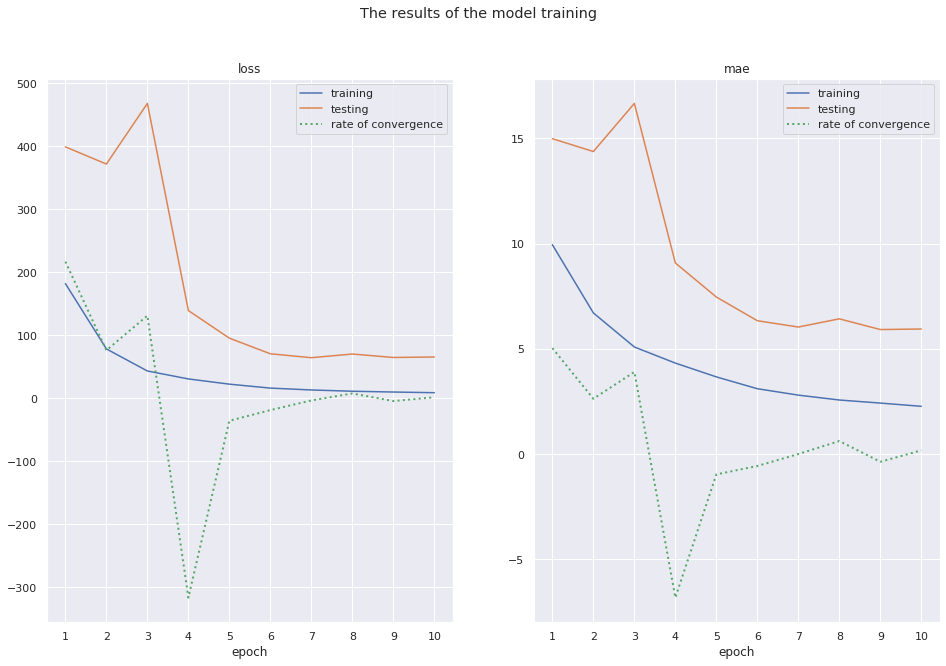

In [19]:
plt.figure(figsize=(16, 10))
plt.suptitle('The results of the model training')

for i in range(len(training_process_dataframe.columns)//3):
    legend = []
    plt.subplot(121+i)
    plt.title(training_process_columns[i])
    
    sns.lineplot(data=training_process_dataframe[training_process_dataframe.columns[i]])
    legend.append('training')

    sns.lineplot(data=training_process_dataframe[training_process_dataframe.columns[i+2]])
    legend.append('testing')
    
    plt.plot(training_process_dataframe.index,
             training_process_dataframe[training_process_dataframe.columns[i+4]],
             linewidth=2,
             linestyle=':'
            )
    legend.append('rate of convergence')
    
    plt.xticks(np.linspace(1, 10, 10).astype('int'))
    plt.xlabel('epoch')
    plt.legend(legend)

plt.show()

От эпохи к эпохе ряды сходятся всё **медленнее**. Функция потерь и метрика качества модели: в **последние** несколько эпох **скорость сближения** их значений, полученных на тренировочной и тестовой выборках, стремится к **нулю**. Это означает, что обучение достигло своего **предела**, и метрики более не улучшаются. Обучение можно считать **завершённым**.

##  Вывод по обучению модели - общий вывод

#####  Результаты обучения

Обучение модели прошло успешно.  
Полученное значение метрики: *MAE* = 5.9.  
Требование ТЗ: *MAE* < 8.0.

Требование ТЗ выполнено.

##### Прогресс обучения

Обучение прошло за 10 эпох - этого оказалось достаточно. Ряды значений функции потерь *MSE* и метрики качества *MAE* на обучающей и тестовой выборках сходятся эпоха за эпохой. При этом скорость схождения на последних эпохах снизилась почти до нуля, что говорит о достаточности выполненного и нецелесообразности дальнейшего обучения (результат может даже ухудшиться из-за переобучения).

Выбросы на третьей и восьмой эпохах - случайные. Это нормально, и на них не стоит обращать внимания.

Аугментация и объединение возрастов в группы не потребовались: для обучения хватило датасета в исходном состоянии. Не потребовались и дополнительные слои сети: хватило минимально необходимого набора.

#####  Оценка результатов обучения

Полученная точность оценки возраста покупателя - плюс-минус 6 лет. Для того, чтобы предлагать покупателю товары с учётом его возрастной группы, такая точность подойдёт.

Для контроля добросовестности кассиров при продаже алкоголя такой точности будет недостаточно: модель может перепутать 15-летнего подростка и 22-летнего вполне взрослого человека. Таким образом, в этой части модель может быть лишь вспомогательным средством, а приоритет должен быть отдан более надёжным и точным методам контроля.

Например, с помощью модели можно точно ответить на вопрос, проверил ли кассир документы у покупателя, который, возможно, не проходит по возрасту (потребуются данные системы видеонаблюдения). Проверяемые эпизоды - те, в которых покупателю может быть меньше 18 лет с учётом разброса оценки возраста: допустим, все покупатели в возрасте до 24 лет по оценке модели. Полностью же автоматизировать процесс чётко по принципу "продавал - не продавал лицам моложе-старше восемнадцати" с этой моделью не получится.

*Не исключено, что точность в окрестностях значения "18" будет заметно выше средней в силу особенностей распределения. Поскольку у автора нет доступа к более подробным результатам расчёта, рекомендации остаются в силе. Описанные проблемы, пусть и в меньшей степени, всё равно остаются актуальными.*

##### Заключение

Модель рекомендуется к внедрению для автоматизации рекомендательной системы. При этом специалистам маркетинговой службы заказчика необходимо учитывать довольно широкий разброс ответов модели относительно реального возраста покупателя.

Модель рекомендуется к внедрению для контроля добросовестности кассиров при продаже алкоголя, но только лишь в качестве вспомогательного средства, так как не позволяет сделать такой контроль полностью автоматическим (без участия человека) с приемлемой точностью. Модель сэкономит время, делая проверяемую выборку более узкой (отбросит заведомо более старших покупателей), или повысит эффективность работы контролирующего работника, следящего за кассирами онлайн (позволит уменьшить количество контролёров).